# 재미로 만들어보는 카카오톡 단톡방 분석 스크립트

1st commit: 2021-08-31 12:30. 뼈대 작업.  
2nd commit: 2021-09-01 01:06. Raster plot 추가.  
3rd commit: 2021-09-01 02:55. 한글버전/영어버전 export 호환성 개선.  


### 1. 환경 및 경로 설정



In [7]:
import re
import pandas as pd; import datetime as dt; import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import locale; locale.setlocale(locale.LC_ALL, 'ko_KR.UTF-8')
import os
from glob import glob
datadir = './'
#datadir = 'C:/Users/Gbook-Jeelab/Desktop/'
filelist = glob(datadir+'*.txt');filelist.sort();

# File selection
filename = filelist[-1]

# Autodetect KOR/ENG version (export executed in which version of OS)
if 'Date' == open(filename, 'r', encoding="utf-8").readlines()[1][:4]:
    export_version = 'Eng' #'Kor'
else:
    export_version = 'Kor' #'Kor'

print('(%s ver.) Selected file -> [%s]'%(export_version,filename))


(Eng ver.) Selected file -> [.\sample.txt]


### 2. 텍스트 라인 포맷에 맞게 잘라내는 함수 정의

In [8]:
""" English version """
def parse_line( txt, export_version=export_version ):
    txt_split = txt.split(',')
    if export_version == 'Eng':
        time_ = txt_split[0]+','+txt_split[1]
        id_ = txt_split[2].split(':')[0][1:-1].split('/')[0]
        contents_ = txt_split[2].split(':')[1][1:-1]
    elif export_version == 'Kor':
        time_ = txt_split[0]
        id_ = txt_split[1].split(':')[0][1:-1].split('/')[0]
        contents_ = txt_split[1].split(':')[1][1:-1]
    contents_ = re.compile('[ㄱ-ㅎ|ㅏ-ㅣ]').sub('',contents_)
    
    return time_, id_, contents_

### 3. chat_data 폴더에 있는 모든 텍스트파일 긁어와서 list에 넣기 

In [9]:
lines, ids, times = [], [], []
for fileIdx in range(len(filelist)):
    print('Opening .... Filename : [%s]'%filelist[fileIdx])
    chat = open(filelist[fileIdx], 'r', encoding="utf-8").readlines()[8:]
    for lineIdx in range(len(chat)):
        line = chat[lineIdx]
        if line is not '\n':
            try: # 현재 버전에서는 첫 줄만 가져옴. 향후 줄바꿈(\n)을 제거해서 긴 글도 가져올 필요 있음.
                if export_version == 'Kor':
                    if line[0]=='2': # 이 조건문 조금 더 정교하게 만들 필요 있음. 지금 너무 못 생김.
                        time_, id_, contents_ = parse_line(line)
                        ids.append(id_); 
                        lines.append(contents_)
                        times.append(time_); 
                else:
                    time_, id_, contents_ = parse_line(line)
                    ids.append(id_); 
                    lines.append(contents_)
                    times.append(time_); 
            except:
                pass
        
# Save option
saveOpt = True
if saveOpt:
    df = pd.DataFrame( {'timestamp':times, 'nickname':ids, "contents":lines })
    writer = pd.ExcelWriter('chat_data.xlsx', engine='xlsxwriter')
    df.to_excel(writer, sheet_name='Sheet1')
    writer.close()

Opening .... Filename : [.\sample.txt]


### 4. 이름 별 채팅 횟수 계산 / Rank 나타내기

[Rank 01] 이재: 32
[Rank 02] 효빈: 31
[Rank 03] 김보: 22
[Rank 04] 김정: 19
[Rank 05] 이규: 12
[Rank 06] 이유: 6
[Rank 07] 박지: 4
[Rank 08] 김해: 2
[Rank 09] 김서: 1


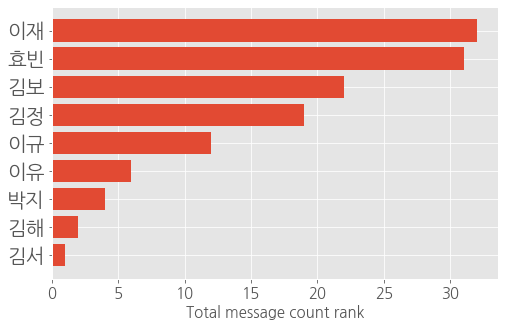

In [10]:
nicknames = df['nickname'].to_list()

# Count
from collections import Counter
count = dict( Counter(nicknames) )
names = list(count.keys())
counts = np.array(list(count.values()))

# Sort & formulate x, y data
rank = counts.argsort()
names_by_rank, counts_by_rank = [],[]
for rankIdx in range(len(rank)-1,-1,-1):
    # 이름 공개를 피하기 위해 앞 2글자만 쓰기( [:2] )
    print('[Rank %02d] %s: %d'%(len(rank)-rankIdx,names[rank[rankIdx]][:2], counts[rank[rankIdx]]))
    names_by_rank.append(names[rank[rankIdx]][:2]); counts_by_rank.append(counts[rank[rankIdx]])
    #print('[Rank %02d] %s: %d'%(len(rank)-rankIdx,names[rank[rankIdx]], counts[rank[rankIdx]]))
    #names_by_rank.append(names[rank[rankIdx]]); counts_by_rank.append(counts[rank[rankIdx]])

# Visualization
plt.figure(figsize=(8,5))
plt.barh(names_by_rank, counts_by_rank)
ax = plt.gca(); ax.invert_yaxis(); #ax.set_xscale('log')
plt.xlabel('Total message count rank', fontsize=15)
ax.tick_params( axis='y', labelsize= 20 )
ax.tick_params( axis='x', labelsize= 15 )


### 참고) 그림에서 한글이 깨지는 경우 해결법

*** ***
*** (1) Matplotlib Font 헤더파일 변경 ***  

귀찮으니 다음 [블로그 글](https://mimmic.tistory.com/entry/matplotlib-%ED%95%9C%EA%B8%80-%EA%B9%A8%EC%A7%90-%ED%95%B4%EA%B2%B0-%EB%B0%A9%EB%B2%95) 참고.  
  
*** ***
  
*** (2) Matplotlib 패키지 경로에 직접 ttf 파일 넣어주기 ***

Matplotlib 설치 경로는 아래 코드 실행으로 알아볼 수 있고,

``` python
import sys
sys.executable 
```

위 코드의 실행 결과로, 지금 이 local machine의 경우엔 C:\ProgramData\Anaconda3\python.exe 가 뜬다.  
만약 이런 경우엔, [하위 경로](C:\ProgramData\Anaconda3\Lib\site-packages\matplotlib\mpl-data\fonts\ttf)(C:\ProgramData\Anaconda3\Lib\site-packages\matplotlib\mpl-data\fonts\ttf)를 열어서  
폰트 파일(NanumGothic.ttf) 파일을 넣어주면 됨.
*** ***


### 5. 특정 이름 가진 사람만 분석하기

***target_id*** 변수 설정을 통해, 특정 id를 가진 사람의 발화 내용과 시점을 아래와 같이 가져올 수 있음.

In [11]:
# 계산 편의를 위해 리스트로 변환
nicknames = df['nickname'].to_list()
timestamps = df['timestamp'].to_list()
contents = df['contents'].to_list()

target_id = '효빈'
times = [timestamps[i] for i in range(len(nicknames)) if target_id in nicknames[i]]
lines = [contents[i] for i in range(len(nicknames)) if target_id in nicknames[i]]

#print('발화 시점: %s\n'%times)
#print('발화 내용: %s'%lines)

### 6. 발화자 별 발화 시점 구하기

발화 시점을 구하기 앞서, 카카오톡 채팅 export 기능에서 제공하는 timestamp string를 정규식으로 변환해줄 필요가 있음.  
이를 위해, string을 받아 숫자(float) 형식으로 된 timestamp를 return해주는 함수를 먼저 구현해야 함.



In [12]:
from time import mktime
from datetime import datetime
from calendar import monthrange

""" English version """
def format_datestr( string_in, export_version = export_version ):
    if export_version == 'Eng':
        # Parse input
        md_str, yHM_str = string_in.split(',')[0], string_in.split(',')[1][1:]
        y = int(yHM_str.split(' ')[0])
        m = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'].index(md_str.split(' ')[0])+1
        d = int( md_str.split(' ')[1] )
        H = int( yHM_str.split(' ')[1].split(':')[0] )
        if yHM_str.split(' ')[-1] == 'PM': H += 12
        M = int( yHM_str.split(' ')[1].split(':')[1] )
        
    elif export_version == 'Kor':
        # Parse input
        split_str = string_in.split('.')
        y,m,d = int(split_str[0]), int(split_str[1]), int(split_str[2])
        PM = split_str[-1].split(' ')[1] == '오후'
        HM_str = split_str[-1].split(' ')[2]
        H = int( HM_str.split(':')[0] )
        if PM: H += 12
        M = int( HM_str.split(':')[1] )        
        
    # Correct day-, month-, or year-passing
    if H>=24: 
        d += 1; H -= 24
    if d > monthrange(y, m)[1]:
        m += 1; d = 1
    if m > 13:
        y += 1; m = 1
        
    # Output arguments
    string_out = '%04d-%02d-%02d %02d:%02d:00'%(y,m,d,H,M)
    abs_time = mktime(datetime.strptime(string_out,'%Y-%m-%d %H:%M:%S').timetuple())
    return string_out, abs_time    


#def which_day(y,m,d):return ['MON','TUE','WED','THU','FRI','SAT','SUN'][datetime.date(y,m,d).weekday()]

이 함수를 이용해, 아래와 같이 생긴 2차원의 binary matrix를 구현한 뒤 이를 raster plot으로 시각화.

참고로 raster_matrix는 아래와 같이 생김

``` python
                <- 시간 축 -> (시간은 분 단위)
발화자 1 - [ 0 0 0 0 1 0 0 0 1 0 1 ... 0 ]
발화자 2 - [ 1 0 0 0 1 0 0 0 0 0 0 ... 0 ]
발화자 3 - [ 0 0 1 0 1 0 0 0 1 0 0 ... 0 ]
발화자 4 - [ 0 0 0 0 0 0 1 0 1 0 1 ... 0 ]
...
```

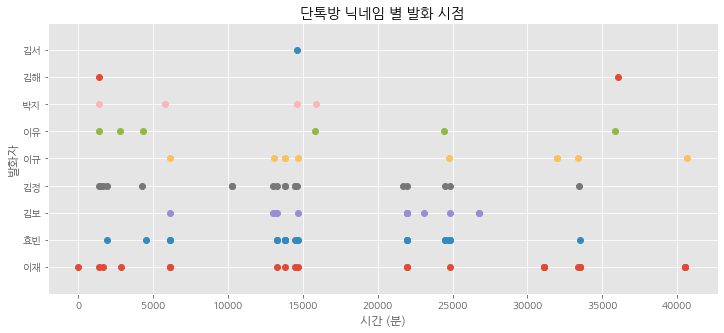

In [13]:
# Formatting [Timestamp, Nickname] 2D matrix (타이밍 딕셔너리)
when_by_whom = np.zeros( (df.shape[0],2), dtype=int)
for lineIdx in range(df.shape[0]):
    by = names_by_rank.index(df['nickname'][lineIdx][:2])
    _, timestamp = format_datestr( df['timestamp'][lineIdx] )
    if lineIdx==0: timestamp_base = timestamp
    when_by_whom[lineIdx,:] = [(timestamp-timestamp_base)/60, by] # To set its unit to "minute"

# Formatting 2D binary matrix
raster_matrix = np.zeros( (when_by_whom[-1,0]+1,len(names_by_rank)), dtype='bool')
for lineIdx in range(when_by_whom.shape[0]):
    raster_matrix[ when_by_whom[lineIdx,0], when_by_whom[lineIdx,1] ] = True

# Visualization (raster plot)
plt.figure(figsize=(12,5))
for nameIdx in range(raster_matrix.shape[1]):
    x = np.where(raster_matrix[:,nameIdx])[0]
    y = np.zeros(x.shape[0])+nameIdx
    plt.plot(x,y,'o')
ax = plt.gca()
ax.invert_yaxis()
plt.yticks( ticks = range(len(names_by_rank)), labels = names_by_rank )
plt.ylim((-1, len(names_by_rank)))
plt.title('단톡방 닉네임 별 발화 시점')
plt.xlabel('시간 (분)')
plt.ylabel('발화자');
